# Morning: Introduction to Time Series Analysis

In this set of exercises we study the basic concepts of statistical time series. We focus on the foundational concepts of *autocorrelation* (https://en.wikipedia.org/wiki/Autocorrelation) and *periodicity* (or *seasonality*) (https://en.wikipedia.org/wiki/Seasonality). Being a statistics workshop, we'll focus on the general quantitative characteristics of time series that require attention to draw proper statistical conclusions from data. This essentially boils down to understanding the consequences of spatial-temporal properties on the calculation of confidence intervals, p.values, posterior probabilities, and other related metrics that quantify statistical evidence. Understanding autocorrelation and periodicity will take us a long way to this goal. 

First we import the requried packages. Note we also need to load the required R packages using *importr*. But first we configure the Matplotlib backend to show plots inside the notebook before importing it:

In [1]:
%matplotlib inline

In [23]:
#-- Import Required Python Packages
import numpy as np
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display

#-- Import R packages in Python
r = robjects.r
nlme = importr('nlme')
stats = importr('stats')

## Is there a trend?

Here we read in our first real dataset that exhibits typical properties of an environmental time series, and of time series more generally. The measurements are of monthly-averaged sea surface temeprature (SST) for a region of the sea surface enclosed by 5°N–5°S, 120°–170°W, recorded by the National Oceanic and Atmospheric Adminstration (NOAA) and published publically to their website. This particular measurement is used widely as an index of the El Nino phenomena (https://en.wikipedia.org/wiki/El_Ni%C3%B1o) that plays an important role in global climate, and Californian climate in particular. The sea surface measurement represent monthly temperature averages (12 measurements per year) taken by series of measurement techniques including moored buoys and in-situ sampling, averaged according to an assumed measurement error of each technique.  


We load the text file as ``sst``, extract our variable of interest ``y`` (sea surface temperature), and define the time variable ``t`` (months). 

We then go ahead and plot the data with matplotlib. 

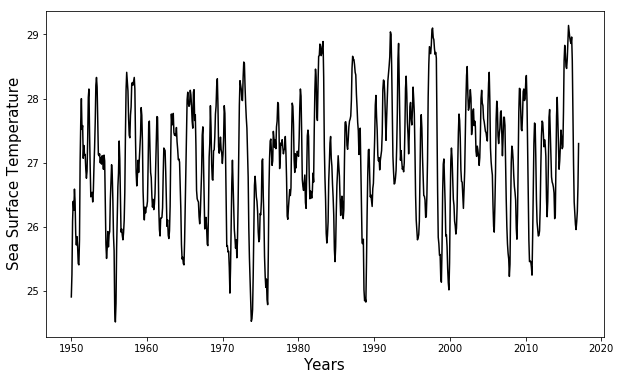

In [3]:
sst = np.loadtxt('../Data/detrend.nino34.ascii.txt',skiprows=1) # Get El Nino data from file (included in repository)
y = sst[:,2]                                      # Extract SST measurements
t1 = np.linspace(1950,2017,len(y))                # Define time axis

#-- Plot time-series
fig = plt.figure(figsize=(10,6))                  # Set up figure
plt.plot(t1,y,'k-')                               # Plot SST as a line
plt.ylabel('Sea Surface Temperature',fontsize=15) #label y-axis
plt.xlabel('Years',fontsize=15)                   #label x-axis
plt.show()

Our first question is perhaps the simplest and most common question asked in applied time series analysis: *Is there a trend over time?* Take a hard look at the plot and write down what you'd guess, yes or no. We'll go back and test our initial intuition after learning a bit of theory.  

The simplest statistical trend model is a linear regression with respect to time

$$ y_i = \beta t_i + e_i $$

where $y_i$ indicates is a single observation which is a function of the slope with respect to time $\beta$ multiplied by the $t_i$ variable which represents the time elapsed from the beginning of the time series, while $e_i$ is the background variability not accounted for by the model. We assume this variable has a *Normal* (or *Gaussian*) *distribution*. We often write this statistical model as $e_i \sim N(0,\sigma^2)$ where $\sigma^2$ is the variance of the Normal distribution. It will also be helpful to write the model in vector notation  

$$ \mathbf{y} = \beta \mathbf{t} + \mathbf{e} $$

where the bold-faced type indicates the full vector, or column, of values, with $\mathbf{t}$ representing the set of sequentially increasing time values, and $\mathbf{e}$ is a *random vector* with *covariance matrix* $\mathbf{\Sigma}$. We will learn to love the covariance matrix. It will be the central quantity required to extend basic statistical concepts to encompass spatial-temporal data. 

## Statistical independence
Statistical independence is a central idea in the workshop and is intimately related to concepts of covariance. Many statistical analysis proceed under the assumption of independence but this will often be violated when dealing with spatial-temporal data.  To jog your memory, the covariance between two *random variables* (i.e. a variable decribed by a statistical distribution, opposed to a single value) is 

$$ \mathrm{cov}(x,y) = \mathrm{E}\left[ (x-\mathrm{E}[x])(y-\mathrm{E}[y]) \right] $$

where the $\mathrm{E}$ is used in statistics to denote a theoretical average with respect to the random variables $x$ and $y$. With a sample of data, we calculate the *empirical* or *sample covariance*

$$ \mathrm{\hat{cov}}(x,y) = \frac{1}{n} \sum_{i=1}^n (x_i-\bar{x})(y_i-\bar{y}) $$

where the sum is taken over all individual data points $i$, while $\bar{x}$ and $\bar{y}$ represent the sample (arithmetic) average of $x$ and $y$, respectively, and $\hat{}$ notation represents an empirical estimate. Note that the correlation between two variables, $\mathrm{cor}(x,y)$ is simply the covariance devided by a measure of total variance

$$ \mathrm{cor}(x,y) = \frac{\mathrm{cov}(x,y)}{\sigma_x \sigma_y}  $$

where $\sigma_x$ and $\sigma_y$ are the standard deviations for the variables $x$ and $y$, respectively. If the two variables are independent, then $\mathrm{cov}(x,y) = 0$ theoretically, and $\mathrm{\hat{cov}}(x,y) = 0$, on average based on observed realizations of the random variable.

In our regression model, the assumption of independence enters via the covariance matrix of the model errors. When a random vector is assumed to have independent elements, it has a covariance with diagonal elements according to the variances of each variable. And further, if we assume that each variable has the same variance then the covariance matrix has the following form

$$ \mathbf{\Sigma}_{iid} = \begin{bmatrix}
	  	\sigma^2 &        0 &  \dots & 0 \\
  			   0 & \sigma^2 &   \dots & 0 \\
          \vdots &   \vdots &\ddots & \vdots  \\
               0 &        0 &\dots  & \sigma^2     \end{bmatrix} =
        \sigma^2 \begin{bmatrix}
	  	       1 &        0 &  \dots & 0 \\
  			   0 &        1 &  \dots & 0 \\
          \vdots &   \vdots &\ddots & \vdots  \\
               0 &        0 &\dots  & 1     \end{bmatrix} $$
               
where $\sigma^2$ is the variance, which is factored on the right as the multiplication of the variance times the correlation matrix. This diagonal (independent) form is the most commonly used form of the Gaussian distribution and is the basis of many statistical models in statistics. 

In general, the way to intpret this matrix is as a big list of covariances (or correlations) between our random variables (recall in statistics we treat each data point as a random variable, where the paricular observation is the realized value from that random variable). Each $i^{th}$ column is a list of the covariances between datapoint $i$ and all datapoints in the dataset. When data are independent, all covariances are zero and so takes this simple diagonal form. 

## The likelihood function for independent data
The background theory for regression and many other statistical models is the likelihood function. It represents the probability of the observations under the assumption of a particular statistical distribution (https://en.wikipedia.org/wiki/Likelihood_function). We write the likelihood function for an independent random vector

$$ p(\mathbf{y} | \theta,M, \sigma^2) = \prod_{i=1}^n p(y_i | \theta,M,\sigma^2) = \left( \frac{1}{2\pi\sigma^2}\right)^{n/2} \mathrm{exp} \left( -\frac{\sum_{i=1}^n e_i^2}{2\sigma^2	}  \right) $$

This is the function that is maximized when one fits a basic statistical model. For simple models, there are generally analytic expressions which is generally where all those annoying formulas come from in introductory statistics. For more complex models, this function is treated numerically on the computer. And also note this function is central to both classical (or *frequentist*) statistics one typically maximizes this function with respect to the parameters to obtain the maximum likelihood parameter estimates. In Bayesian statistics, one multiplies this function by a specified *prior probability distribution* and integrates to yield *posterior probability distribution*. (See https://en.wikipedia.org/wiki/Proofs_involving_ordinary_least_squares#Maximum_likelihood_approach to see how the formula for linear regression are derived by maximizing the likelihood function.). Some may recall that linear algebra provides a very compact expression for the parameters that maximize the likelihood of an ordinary least squares regression (https://en.wikipedia.org/wiki/Linear_least_squares_(mathematics))

$$ \mathbf{\hat{\beta}} = \mathbf{(X'X)^{-1}X'y}  $$

where $\mathbf{X}$ in this case is a matrix formed with a vector of ones and the variable $\mathbf{t}$ as its columns. 

Now we use rpy2 to fit this common regression model with `R` packages in Python. Note first we have to convert each Python object to an R object and pass it along to the R "global environment" using `robjects.globalenv`.

In [4]:
robjects.globalenv["y"] = robjects.FloatVector(y)   # Add y to the R environmental as a FloatVector R object
robjects.globalenv["t1"] = robjects.FloatVector(t1) # Add y to the R environmental as a FloatVector R object
fit = r.lm("y ~ t1")                                # linear fit with model y ~ t1
#return summary of fit, including everything after the word "Resduals" to avoid the long "call" information.
print str(r.summary(fit))[str(r.summary(fit)).find("Residuals:"):]  

Residuals:
    Min      1Q  Median      3Q     Max 
-2.4020 -0.6441  0.0608  0.6246  1.9709 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 10.688845   3.290339   3.249  0.00121 ** 
t1           0.008230   0.001659   4.961 8.55e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.9125 on 805 degrees of freedom
Multiple R-squared:  0.02967,	Adjusted R-squared:  0.02846 
F-statistic: 24.61 on 1 and 805 DF,  p-value: 8.551e-07




This is the typical output from a regression that ``R`` and ``Python`` users will be familiar with. It is referred to as the $t-table$ or $ANOVA$ table. While we won't get into what all the values mean, since these quantities are the focus of introductory courses, we will note the *t-statistic* which is formed by taking the ratio of the slope magnitude to the magnitude of its standard error

$$ t = \frac{\hat{\beta}}{s.e.(\hat{\beta})}   $$

which we will use as a rough-and-ready measure of statistical confidence in a particular estimate. We generally will not incorporate $p.value$ interpretations into our analysis, although one should recall that $p.value$ statements are derived from the calculated $t$ statistic. As a rough rule of thumb, smallter $t$ values indicate lower confidence in the presence of an effect. The $t$ statistic calculated above indicates relatively strong evidence for a trend (as indicated by the small p.value). To jog the memory of hypothesis testing via $t$ statistics is found: https://en.wikipedia.org/wiki/Student%27s_t-test   

## Temporal dependence
Now we look at a very simple time series model that violates the assumptions of temporal independence. And as we'll see, it's actually a very useful model to model time series in a variety of situations. This is the *first-order autoregressive model*, or *AR1*. We write this model

$$ y_{t+1} = \phi y_t + e_t  $$

where now we are using $y$ to refer to a general time series, here shown at individual time points $t+1$ or $t$, $e_t$ is another general Normal random variable with variance $\sigma^2$, while $\phi$ is the *autoregressive coefficient* which can take values anywhere on the interval $(-1,1)$.  

The main characteristic of this model we wish to study is its *autocorrelation*. Fundamentally, we'll see that values nearer to one another are more similar than values further away. This will be a key concept throughout the time series and spatial analysis sections. We'll see that autocorrelation generates larger *random* flucuations that need to be accounted for when statistically analyzing data. 

Before diving too much further in, let's get a sense for independent and non-indendent data via simulation. The code below generates sample realizations to compare the output from independent time series and that generated by our $AR1$ model. We also use the `R` command `rnorm(n,mean,sd)`, which takes the size of the realization as its first arguement, the mean of the normal distribution as its second, and the standard deviation as its third.

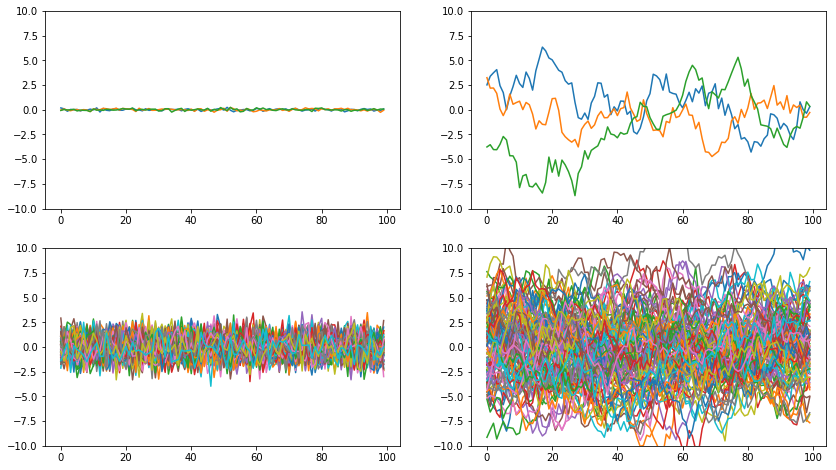

In [5]:
n  = 100
phi = 0.95
s = 0.1

fig, ax = plt.subplots(2,2,figsize=(14,8)) # Set up figure and subplots
#-- 3 sample realizations
for i in range(3):
    ax[0,0].plot(np.array(r.rnorm(n,sd=s)))  # purely random process;
    # autoregressive model with autoregressive coefficient 0.95
    ax[0,1].plot(np.array(stats.arima_sim(100,model=robjects.ListVector({'ar':phi,'sd':s})))) 
    ax[0,0].set_ylim([-10,10])            # y range for first plot 
    ax[0,1].set_ylim([-10,10])            # y range for second plot
#-- Same as above but with 100 sample realizations
for i in range(100):
    ax[1,0].plot(np.array(r.rnorm(n)))  
    ax[1,1].plot(np.array(stats.arima_sim(100,model=robjects.ListVector({'ar':phi}))))
    ax[1,0].set_ylim([-10,10])
    ax[1,1].set_ylim([-10,10])
plt.show()

### Exercise
In the cell below, try altering the *ar*, and *s* parameters to see how the parameters alter the characteristic flucuations of the time series. Remember, there is nothing going on in these time series except for random noise and autocorrelation.

##  Autocovariance
Now that we have seen how autocorrelation parameter alters the behaviour of time series, we are going to extend the concept of covariance to time series. Instread of thinking about covariance as between two different variables $x$ and $y$, like we did above, think of covariance among different time points in a single time series $x$ (here referring to a general $x$ that could, for example, represent $y_i$ or $e_i$ in our trend regression above). In a similar way to how we defined covariance between $x$ and $y$, we can describe autocorrelation as the following

$$ \mathrm{cov}(x_i,x_{i+\tau}) = \mathrm{E}\left[ (x_i-\mathrm{E}[x])(x_{i+\tau}-\mathrm{E}[x]) \right] $$

where $\tau$ is the distance, or *lag* separating the two elements in the time series. If points in time are independent, then $\mathrm{cov}(x_i,x_{i+\tau}) = 0$.


## The autocorrelation function
And like above, we'll consider covariance *matrices* where a single variance can be separated from the pattern of correlations among the variables. Writing the elements of the correlation matrix with generic values

$$ \mathbf{\Sigma} = \sigma^2 \begin{bmatrix}
         	      1 &     c(x_1,x_2) &     c(x_1,x_3) &          \dots & c(x_1,x_n) \\
         c(x_2,x_1) &              1 &     c(x_2,x_3) &         \ddots & c(x_2,x_n)  \\
         c(x_3,x_1) &     c(x_3,x_2) &              1 &         \ddots & \vdots \\
             \vdots &         \ddots &         \ddots &         \ddots & c(x_{n-1},x_n)  \\
         c(x_n,x_1) &     c(x_n,x_2) &          \dots & c(x_n,x_{n-1}) & 1     \end{bmatrix} $$

where $c(x_i,x_j)$ is the correlation between variable $x_i$ and $x_j$. What we want is a function that can be used to 'fill in' the values of this correlation matrix, and then we can go ahead and incorporate this matrix into our analyses. Very commonly in natural processes, the autocorrelation function for a dataset will take a form where values closer to another are more similar. This general situation requires an autocorrelation that take *distance* or *lag* between variables as its input

$$ c(x_t,x_{t+\tau}) = \mathrm{cor}(x_t,x_{t+\tau}) $$

In this case we are taking about lags in time, but we'll see later on the concept generalizes to spatial dimensions as well.

## The empirical autocorrelation function
We can think about either theoretical or empirical autocorrelation functions. The empirical autocorrelation is actually easy to understand. We're interested in correlations as a function of lag and with a sample of data we can form lagged pairs with the data and estimate their correlation.

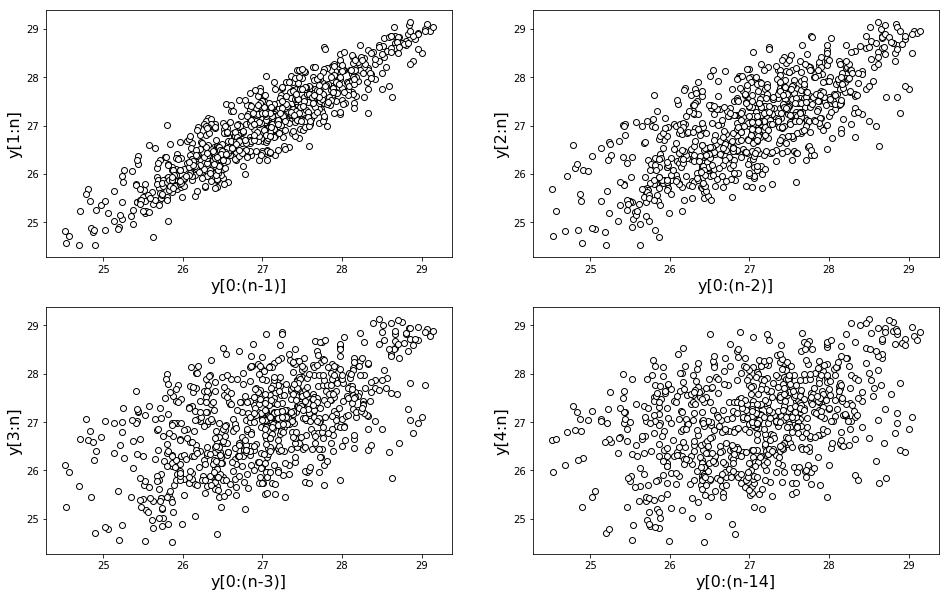

In [6]:
fig, ax = plt.subplots(2,2,figsize=(16,10))            # Set up figure and subplots
ax[0,0].scatter(y[:-1],y[1:],edgecolor='k',facecolor='w')      # scatter plot of values shifted by 1
ax[0,0].set_xlabel('y[0:(n-1)]',fontsize=16)            # x axis label
ax[0,0].set_ylabel('y[1:n]',fontsize=16)                # y axis label
ax[0,1].scatter(y[:-2],y[2:],edgecolor='k',facecolor='w')      # scatter plot of values shifted by 2
ax[0,1].set_xlabel('y[0:(n-2)]',fontsize=16)            # x axis label
ax[0,1].set_ylabel('y[2:n]',fontsize=16)                # y axis label
ax[1,0].scatter(y[:-3],y[3:],edgecolor='k',facecolor='w')      # scatter plot of values shifted by 3
ax[1,0].set_xlabel('y[0:(n-3)]',fontsize=16)            # x axis label
ax[1,0].set_ylabel('y[3:n]',fontsize=16)                # y axis label
ax[1,1].scatter(y[:-4],y[4:],edgecolor='k',facecolor='w')      # scatter plot of values shifted by 4
ax[1,1].set_xlabel('y[0:(n-14]',fontsize=16)            # x axis label
ax[1,1].set_ylabel('y[4:n]',fontsize=16)                # y axis label
plt.show()

In ``R`` we can compute the correlations from all these lagged pairs via the convienient command ``acf()``. In R this would also plot the results. You will get an `R` plot in a separate window. However, in order to make a `matplotlib` plot, in `Python` we would have to extract the results as numpy arrays and plot them, as shown below.  And note that we can standardize relative to the total variance, or not, yielding the *autocorrelation* and *autocovariance* functions, respectively.

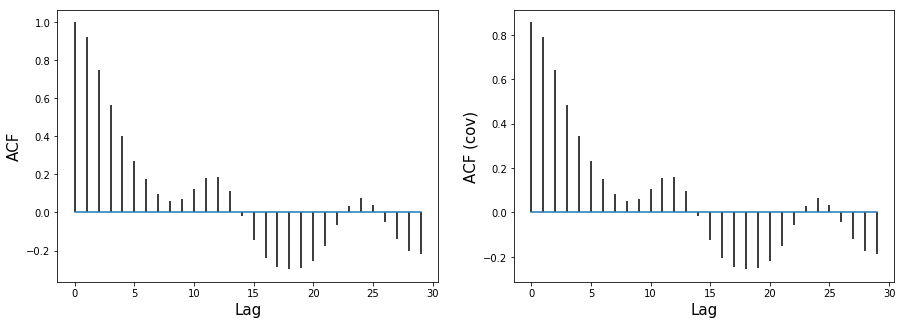

In [7]:
fig, ax = plt.subplots(1,2,figsize=(15,5))            # Set up figure and subplots
acf_corr = np.squeeze(np.array(stats.acf(robjects.FloatVector(y), ci=0, main='', type='correlation')[0]))
acf_cov = np.squeeze(np.array(stats.acf(robjects.FloatVector(y), ci=0, main='', type='covariance')[0]))
n = len(acf_corr) #number of lags
#-0 Plot Autocorrelation
ax[0].vlines(range(n),[0],acf_corr)       # plot vertical lines
ax[0].plot(range(n),np.zeros(n))          # plot zero line
ax[0].set_ylabel('ACF',fontsize=15)       # label y axis  
ax[0].set_xlabel('Lag', fontsize=15)      # label x axis
#-- Plot Autocovariance
ax[1].vlines(range(n),[0],acf_cov)        # plot vertical lines
ax[1].plot(range(n),np.zeros(n))          # plot zero line
ax[1].set_ylabel('ACF (cov)',fontsize=15) # label y axis
ax[1].set_xlabel('Lag',fontsize=15)       # label x axis
plt.show()

## Autoregressive autocorrelation function
It turns out that our first order autoregressive process ($AR1$) has a very nice formula to fill in the values of our correlation matrix

$$ c(x_t,x_{t+\tau}) = \phi^{\tau}. $$ 

which says that the correlation is simply a function of lag between pointsm and by knowing $\phi$ we can fill in the values of the matrix. This will the autocorrelation function that we will use to analyze time series. It is perhaps the most fundamental and widely used model for this purpose. The  

$$ \mathbf{\Sigma}_{AR1} = \sigma^2 \begin{bmatrix}
	  	       1 &   \phi & \phi^2 &  \dots & \phi^n \\
  		  \phi &        1 &  \phi &  \ddots & \phi^{n-1} \\
        \phi^2 &     \phi &     1 &  \ddots & \vdots \\
        \vdots &   \ddots &\ddots &  \ddots & \phi^{n-(n-1)}  \\
        \phi^n &\phi^{n-1}  & \dots & \phi^{n-(n-1)} & 1     \end{bmatrix} $$
               
To understand where the formula comes from we can observe the following

$$ \bar{y}_{t+\tau} = \phi \bar{y}_{(t+\tau)-1} = \phi( \phi \bar{y}_{(t+\tau)-2}) = ,..., = \phi^n \bar{y}_{t-n}.$$

Now we will try to estimate an autocorrelation function from the time series. First we find the empirical correlation between values lagged by one unit. We then construct the *theoretical autocorrelation function* according to an autoreggressive statistical process. Overtop we plot the *empirical autocorrelation function* using the ``plot_acf`` function in the ``statsmodel`` module (the `Python` version of `acf` in R that we used above, except this function automatically created a `matplotlib` plot), which does the work for you by taking the time series, laging by $\tau$ units and computing the correlation. In the third panel I used am *optimized* value for the autocorrelation function which came from statistically fitting a curve to the empirical autocorrelation function. We'll learn how to do this below. For now, recognize that the empirical autocorrelation has some noise and while the autoregressive model appears to be a good functional form, we can find a better characterize via a statistical fit. 

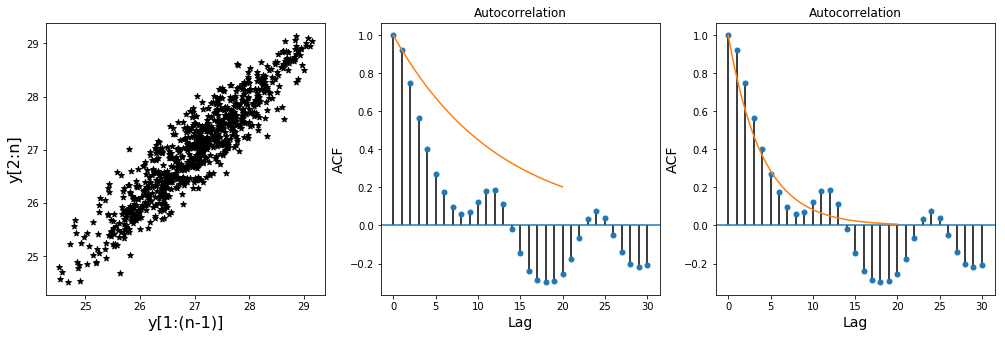

In [8]:
fig, ax = plt.subplots(1,3,figsize=(17,5))            # Set up figure and subplots
ax[0].scatter(y[:-1],y[1:],color='k',marker='*')      # scatter plot of values shifted by 1
ax[0].set_xlabel('y[1:(n-1)]',fontsize=16)            # x axis label
ax[0].set_ylabel('y[2:n]',fontsize=16)                # y axis label
sm.graphics.tsa.plot_acf(y,lags=30,alpha=np.float('nan'),ax=ax[1]) # plot empirical autocorrelation function
alpha_hat = np.corrcoef(y[:-1],y[1:])[0,1]           # the correlation coefficient between lagged values
ax[1].plot(np.linspace(0,20),alpha_hat**np.linspace(0,20))        # line for theoretical acf using correlation coeff
ax[1].set_xlabel('Lag', fontsize=14)                  # x axis label
ax[1].set_ylabel('ACF',fontsize=14)                   # y axis label
sm.graphics.tsa.plot_acf(y,lags=30,alpha=np.float('nan'),ax=ax[2]) # plot empirical autocorrelation function
ax[2].plot(np.linspace(0,20),0.78**np.linspace(0,20)) # plot optimized autocorrelation function (more info below)
ax[2].set_xlabel('Lag', fontsize=14)                  # x axis label
ax[2].set_ylabel('ACF',fontsize=14)                   # y axis label
plt.show()

## Linear regression with autocorrelation
To show you how this works in practice we will again look back to our El Nino time series regression. From observing the El Nino data plot it appears that the observed sst $y$ has autocorrelation - i.e. *values closer to one another seem more similar than values far away*. And although we have not visualized $e_i$, we know from the model that $e$ and $y$ only differ via the subtraction of a straight line, so temporal flucuations in $y_i$ will propagate to $e_i$. For nonlinear models this is more difficult to know *a priori*. 

We can write the likelihood function for the correlated data as follows, now incorporating the general covariance matrix

$$ p(\mathbf{y} | \mathbf{\theta},M, \mathbf{\Sigma}) = \prod_{i=1}^n p(y_i | \mathbf{\theta},M,\mathbf{\Sigma}) = 
	\frac{1}{(2\pi)^{\frac{n}{2}}|\mathbf{\Sigma}|^{\frac{1}{2}}} 
	\mathrm{exp} \left( -\frac{1}{2} \mathbf{e}'\mathbf{\Sigma}^{-1}\mathbf{e}  \right) $$

In the same way we had an expression for maximizing the probability of independent data, there is a formula for the regression parameters in the presents of autocorrelation. This is known as generalized least squares (https://en.wikipedia.org/wiki/Generalized_least_squares).

$$ \mathbf{\hat{\beta}} = \mathbf{(X'\Sigma^{-1}X)^{-1}X'\Sigma^{-1}y}  $$

To fit this model in ``R`` we will use the ``nlme`` package which is a general set of functions for a wide variety of statistical modeling. Let's go ahead and fit it:

In [9]:
# Fit a linear regression between y and time, specifying a first order autoregressive covariance matrix. 
# Specify method='ML' to fit exact maximum likelihood
print r.summary(nlme.gls(r.formula("y ~ t1"), correlation=nlme.corAR1()))

Generalized least squares fit by REML
  Model: y ~ t1 
  Data: NULL 
       AIC      BIC    logLik
  637.1089 655.8723 -314.5545

Correlation Structure: AR(1)
 Formula: ~1 
 Parameter estimate(s):
      Phi 
0.9272067 

Coefficients:
               Value Std.Error   t-value p-value
(Intercept) 5.816964 16.795079 0.3463493  0.7292
t1          0.010672  0.008467 1.2603950  0.2079

 Correlation: 
   (Intr)
t1 -1    

Standardized residuals:
       Min         Q1        Med         Q3        Max 
-2.4783251 -0.6540165  0.1030884  0.6908156  2.0707585 

Residual standard error: 0.9484359 
Degrees of freedom: 807 total; 805 residual



So that was easy. Things look very similar to fitting an ordinary least squares regression. And indeed the output is very similar. But what did we do? We passed the critical command to ``R`` specifying the correlation structure ``corAR1()`` (also part of `nlme`) which indicates to fit a covariance matrix like the one we looked at above. Note the ``method='ML'`` tells ``R`` to use direct maximum likelihood estimation so we can interpret the objective function value which will be helpful below. You should note one critical thing with this fit. We told ``R`` to specify the correlation *structure* but we did not give it a correlation parameter $\phi$. But as you see, the output from ``gls()`` returns a value. This is the optimized value yielded by numerically maximizing the likelihood with respect to this parameter. The essential difference is this: is $\phi$ is known we can directly constuct the covariance matrix and the GLS formula will yield the best estimates and we can derive the appropriate variances. But when $\phi$ is unknown we have to use the computer to find the best values. Notably, the t-statistic is considerably smaller than above! Previously we had calculated a $t$ of 4.961 which strongly suggests a trends, while here our $t$ statistic is ~3.5x smaller. Also note that our linear slope is about 25% larger in magnitude here as well. This often happens. But there is an important result from statistics that says the slope in the two cases should not be systematically different (i.e. the estimate is unbiased), whereas the uncertainty is biased in the sense that ignoring autocorrelation will almost always result in *overconfidence*.

Note that unlike `r.lm()`, the summary of `nlme.gls()` dooes not include extensive "call" information so we didn't have to parse the output of `r.summary()` as we did before.

## Analysis of Orange Country ozone time series
Now lets' dig into a higher resolution, multidimentional dataset, analyzing the air quality monitoring data from the Enrivionmental Protection Agency (EPA). These data are readily used for cutting edge research purposes. In fact, you can find a 2017 PNAS paper analyzing these data and published by an Earth System Science graduate student right here: https://goo.gl/eYTS1O. You can find the larger dataset, including weather stations all over the USA and many more measured parameters, available for download from the EPA here: https://goo.gl/QxJv0y. 

So first we will read in the dataset. For some unknown reason, the EPA website provides data to 2014 with an incomplete 2016 year. To make thing simple we just drop the 2016 year.

In [10]:
d = pd.read_csv('../Data/ozone_orange.csv')      # Read Ozone data from CSV file
ind = np.nonzero(d['year']!=2016)                # Get indices for data before 2016 for simplicity (incomplete chunk of observation)

Now we plot a few of the variables

## Simple trend analysis
Let's try investigating simple linear trends in the ozone data. We're again going to use the ``nlme`` pacakge in ``R`` which optimizes the autoregressive coefficient and accounts for the covariance when calculating uncertainty.  

In [11]:
y1 = np.array(d['ozone'])[ind]                   # Extract the daily mean ozone variable
years = np.array(d['year'])[ind]                 # Extract years
t1 = np.linspace(years.min(),years.max(),len(y1))#define time variable
robjects.globalenv["y1"] = robjects.FloatVector(y1) # Add y1 to R envrionment as FloatVector
robjects.globalenv["t1"] = robjects.FloatVector(t1) # Add y1 to R envrionment as FloatVector
#-- display the summary of a fitted regression with autoregressive covariance matrix
print r.summary(nlme.gls(r.formula("y1 ~ t1"), correlation=nlme.corAR1(),method='ML'))

Generalized least squares fit by maximum likelihood
  Model: y1 ~ t1 
  Data: NULL 
        AIC       BIC   logLik
  -21910.74 -21886.67 10959.37

Correlation Structure: AR(1)
 Formula: ~1 
 Parameter estimate(s):
      Phi 
0.8552849 

Coefficients:
                  Value Std.Error     t-value p-value
(Intercept)  0.03422281 0.6293315  0.05437963  0.9566
t1          -0.00000413 0.0003138 -0.01316690  0.9895

 Correlation: 
   (Intr)
t1 -1    

Standardized residuals:
         Min           Q1          Med           Q3          Max 
-2.056608887 -0.800994961  0.009574762  0.706174031  3.184672958 

Residual standard error: 0.01261744 
Degrees of freedom: 3035 total; 3033 residual



## Harmonic regression
Now we consider another key aspect of time series analysis: *periodicity*. A common seasonality in environmental data is seasonality, but there are often other periodicities as well. For example, El Nino has a somewhat irregular periodicity, with a mean period of approximately seven years. Other environmental phenomena have different periods, including daily, monthly, multidecadal, as well as longer periods present in geological timescales. Of course we didn't have environmental sensors back then, but geologists use proxy records which they analyze to understand much longer periods. 

In general we statistically describe periodicities with sines and cosines, of varying complexity depending on the complexity of the periodic pattern. The simplest form is a single frequency decribed by a single term 

$$ x_t = A\cos(2\pi \omega t + \zeta) $$

$A$ is the amplitude, $\omega$ is the frequency , and $\zeta$ is the phase. Although conceptually simple, this term actually poses a bit of a problem for our linear regression framwork since the phase parameter enters the model nonlinearly and some more complex statistics would be required to fit it. Rest assured there is a common fix to this, involving the double angle formula we learned way back when

$$ \cos(a+b) = \cos(a)\cos(b) - \sin(a)\sin(b).  $$

This formula convieniently allows use two linear terms to model a single period within a linear regression while accounting for the phase. Note the phase no longer enters the model nonlinearly, defining $\beta_1 = A\cos(\zeta)$ and $\beta_2 = -A\sin(\zeta)$

Below we fit a seasonal cycle term. We first find the number of years in the time seasons (i.e. number of seasons) ``nyrs`` 

In [12]:
nyrs= years.max() - years.min()         # number of seasonal cycles [years]
f = np.linspace(0,2*np.pi*nyrs,len(y1)) # nyrs cycles over the length of the time series [radians]
sinf = np.sin(f)                        # sine wave of f
cosf = np.cos(f)                        # cose wave of f

In [13]:
robjects.globalenv["sinf"] = robjects.FloatVector(sinf) # Add sine to R envrionment as FloatVector
robjects.globalenv["cosf"] = robjects.FloatVector(cosf) # Add cose to R envrionment as FloatVector
#-- fit regression with seasonal component and first order autoregressive covariance matrix
print r.summary(nlme.gls(r.formula("y1 ~ sinf + cosf"), correlation=nlme.corAR1(),method='ML'))

Generalized least squares fit by maximum likelihood
  Model: y1 ~ sinf + cosf 
  Data: NULL 
        AIC       BIC   logLik
  -22053.52 -22023.43 11031.76

Correlation Structure: AR(1)
 Formula: ~1 
 Parameter estimate(s):
      Phi 
0.7700548 

Coefficients:
                  Value    Std.Error  t-value p-value
(Intercept) 0.025893952 0.0005036630 51.41126  0.0000
sinf        0.000891778 0.0007113883  1.25357  0.2101
cosf        0.010826465 0.0007096038 15.25706  0.0000

 Correlation: 
     (Intr) sinf  
sinf  0.000       
cosf -0.004  0.000

Standardized residuals:
        Min          Q1         Med          Q3         Max 
-2.97903286 -0.72563451 -0.03934443  0.67355001  3.73500124 

Residual standard error: 0.0100069 
Degrees of freedom: 3035 total; 3032 residual



## Time series decomposition
So now we have seen how to fit both linear trends and periodic regression terms. The best estimate for the individual terms is when you fit these terms simultaneously. Fitting multiple terms like this is often referred to as *time series decomposition* Below we fit the model simultaneously and then plot the individual terms 

In [14]:
# store the model object from the fit above
fit = nlme.gls(r.formula("y1 ~ sinf + cosf + t1"), correlation=nlme.corAR1(),method='ML')

In [15]:
k_hat = fit.rx2('coefficients')          # extract fitted regression coefficients
print k_hat                              # Display for comparison with R
k_hat_var = np.array(fit.rx2('varBeta')) # extract the associated errors
print k_hat_var                          # Display for comparison with R
phi_hat = stats.coef(fit.rx2("modelStruct"),unconstrained=False) #extract fitted autoregressive parameter
e = np.array(fit.rx2('residuals'))       #extract 'raw' residuals (yi - ypred) 

  (Intercept)          sinf          cosf            t1 
-8.728852e-03  8.972455e-04  1.082647e-02  1.726393e-05 

[[  1.51555016e-01  -2.39327705e-05  -1.27465230e-09  -7.55695647e-05]
 [ -2.39327705e-05   5.09997235e-07  -1.55858674e-19   1.19335679e-08]
 [ -1.27465230e-09  -1.55858674e-19   5.03681416e-07  -4.92254945e-19]
 [ -7.55695647e-05   1.19335679e-08  -4.92254945e-19   3.76811591e-08]]


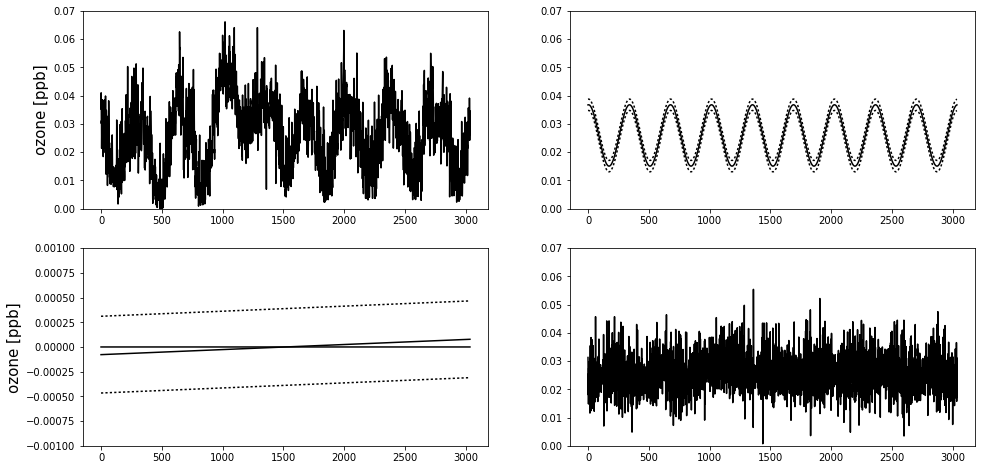

In [16]:
#-- Plot results
fig, ax = plt.subplots(2,2,figsize=(16,8))    # set up figure and panels
ax[0,0].plot(y1,'k-')                         # plot the data
ax[0,0].set_ylim([0,0.07])                    # y axis range
ax[0,0].set_ylabel('ozone [ppb]',fontsize=15) # y axis label

f_hat = np.mean(y1) + k_hat[1]*sinf + k_hat[2]*cosf  # fitted seasonal cycle
ax[0,1].plot(f_hat,'k-')                             # plot fitted seasonal cycle
#-- add 95% CIs (upper and lower); note the variance is already std^2
ax[0,1].plot(f_hat + 2*np.sqrt(k_hat_var[1,1] + k_hat_var[2,2]),'k:') 
ax[0,1].plot(f_hat - 2*np.sqrt(k_hat_var[1,1] + k_hat_var[2,2]),'k:')
ax[0,1].set_ylim([0,0.07])                           # y axis range

t_hat = k_hat[0] + k_hat[3]*t1                       # fitted trend
t_hat -= np.mean(t_hat)                              # normalize to the zero-line
ax[1,0].plot(t_hat,'k-')                             # plot fitted trend
ax[1,0].plot(t_hat + 2*np.sqrt(k_hat_var[3,3]),'k:') # upper 95% CI
ax[1,0].plot(t_hat - 2*np.sqrt(k_hat_var[3,3]),'k:') # lower  95% CI
ax[1,0].plot(np.zeros(len(t_hat)),'k-')              # add 0 line 
ax[1,0].set_ylabel('ozone [ppb]',fontsize=15)        # y axis label
ax[1,0].set_ylim([-0.001,0.001])                     # y axis range

ear = e[1:]-phi_hat*e[:-1]                    # subtract the autoregression
ax[1,1].plot(np.mean(y1)+ear,'k-')            # plot the residuals
ax[1,1].set_ylim([0,0.07])                    # y axis range
plt.show()

The first three plots should be clear, but the fourth may not be so much. We took the residuals from model after removing the fitted terms, and then subtracted the estimates autocorrelation by forming the residuals $$. 

### Exercise
In the cell below, fit other variables in the ozone dataset. Include a trend and the appropriate seasonal terms. Do any other variables show evidence for a trend after controlling for these effects?

## Time series regression
Just like we fit regression using a time variable, we can fit regressions using other independent variables. We can fit the following model

$$ y_i = \beta_0 + \beta_1 x1_i + \beta_2 x2_i, ..., \beta_n xn_i + e_i $$

these variables can be periodic variables or other variables in the dataset. And like above, we characterize the covariance matrix $\Sigma$ using the autoregressive correlation function. 

In Python:

In [26]:
x1 = np.array(d['temp'])[ind]    # Extract temperature
x2 = np.array(d['windsp'])[ind]  # Extract wind speed
x3 = np.array(d['winddir'])[ind] # Extract wind direction
robjects.globalenv["x1"] = robjects.FloatVector(x1)# Add temp to R environment as a FloatVector
robjects.globalenv["x2"] = robjects.FloatVector(x2)# Add wind speed to R environment as a FloatVector
robjects.globalenv["x3"] = robjects.FloatVector(x3)# Add wind dir to R environment as a FloatVector
#-- fit regression with seasonal terms, one input, with autoregressive correlation matrix  
fitx1 = nlme.gls(r.formula("y1 ~ sinf + cosf + x1"), correlation=nlme.corAR1(),method='ML')
# Fit linear regression with seasonal cycle and 3 independent variables; via maximum likelihood method='ML'
fitx123 = nlme.gls(r.formula("y1 ~ sinf + cosf + x1 + x2 + x3"), correlation=nlme.corAR1(),method='ML')
df = pd.DataFrame(data={
    'model':['fitx1','fitx123'],
    'R2':[np.round((np.corrcoef(y1,r.predict(fitx1))[0,1])**2,3)*100,
          np.round((np.corrcoef(y1,r.predict(fitx123))[0,1])**2,3)*100]},
                  columns=['model','R2'])
display(df) #display R2 values
print r.summary(fitx1)           # Display summary of the fitted model
print r.summary(fitx123)         # Display the summary of the model

,model,R2
0,fitx1,37.4
1,fitx123,44.2


Generalized least squares fit by maximum likelihood
  Model: y1 ~ sinf + cosf + x1 
  Data: NULL 
        AIC       BIC   logLik
  -22051.98 -22015.87 11031.99

Correlation Structure: AR(1)
 Formula: ~1 
 Parameter estimate(s):
      Phi 
0.7687963 

Coefficients:
                  Value    Std.Error   t-value p-value
(Intercept) 0.024437725 0.0021696121 11.263638  0.0000
sinf        0.000793210 0.0007218835  1.098807  0.2719
cosf        0.010728155 0.0007200955 14.898239  0.0000
x1          0.000022837 0.0000331050  0.689847  0.4903

 Correlation: 
     (Intr) sinf   cosf  
sinf  0.193              
cosf  0.192  0.039       
x1   -0.973 -0.198 -0.198

Standardized residuals:
        Min          Q1         Med          Q3         Max 
-2.97991106 -0.72750894 -0.04116506  0.67466560  3.74885029 

Residual standard error: 0.009982415 
Degrees of freedom: 3035 total; 3031 residual

Generalized least squares fit by maximum likelihood
  Model: y1 ~ sinf + cosf + x1 + x2 + x3 
  Data: NULL 

# Standardize regression variables for interpretation
In `R` the `scale()` command to remove variables' repsective means and divide by their respective standard deviations. In Python we can just use the `mean` and `std` atributes of `numpy` arrays to perform this. This is the so-called *z-score transform*. It is very useful in statistics because it nondimentionalizes the data and puts everything on the same scale. Now the slope estimate is a direct relative measure of effect magnitude.

In [27]:
x1nrm = (x1-x1.mean())/x1.std()    # scale temp
x2nrm = (x2-x2.mean())/x2.std()    # scale wind speed
x3nrm = (x3-x3.mean())/x3.std()    # scale wind direction
sinfnrm = (sinf-sinf.mean())/sinf.std()
cosfnrm = (cosf-cosf.mean())/cosf.std()
robjects.globalenv["x1nrm"] = robjects.FloatVector(x1nrm)# Add temp to R environment as a FloatVector
robjects.globalenv["x2nrm"] = robjects.FloatVector(x2nrm)# Add wind speed to R environment as a FloatVector
robjects.globalenv["x3nrm"] = robjects.FloatVector(x3nrm)# Add wind dir to R environment as a FloatVector
robjects.globalenv["sinfnrm"] = robjects.FloatVector(sinfnrm)# Add scaled sine to R environment
robjects.globalenv["cosfnrm"] = robjects.FloatVector(cosfnrm)# Add scaled cos to R environment
#-- fit regression with seasonal terms, one input, with autoregressive correlation matrix  
fitx1nrm = nlme.gls(r.formula("y1 ~ sinfnrm + cosfnrm + x1nrm"),
                    correlation=nlme.corAR1(),method='ML')
# Fit linear regression with seasonal cycle and 3 independent variables; via maximum likelihood method='ML'
fitx123nrm = nlme.gls(r.formula("y1 ~ sinfnrm + cosfnrm + x1nrm + x2nrm + x3nrm"),
                      correlation=nlme.corAR1(),method='ML')
df = pd.DataFrame(data={
    'model':['fitx1nrm','fitx123nrm'],
    'R2':[np.round((np.corrcoef(y1,r.predict(fitx1nrm))[0,1])**2,3)*100,
          np.round((np.corrcoef(y1,r.predict(fitx123nrm))[0,1])**2,3)*100]},
                  columns=['model','R2'])
display(df) #display R2 values
print r.summary(fitx1nrm)           # Display summary of the fitted model
print r.summary(fitx123nrm)         # Display the summary of the model

,model,R2
0,fitx1nrm,37.4
1,fitx123nrm,44.2


Generalized least squares fit by maximum likelihood
  Model: y1 ~ sinfnrm + cosfnrm + x1nrm 
  Data: NULL 
        AIC       BIC   logLik
  -22051.98 -22015.87 11031.99

Correlation Structure: AR(1)
 Formula: ~1 
 Parameter estimate(s):
      Phi 
0.7687963 

Coefficients:
                  Value    Std.Error  t-value p-value
(Intercept) 0.025897857 0.0005009692 51.69550  0.0000
sinfnrm     0.000560792 0.0005103646  1.09881  0.2719
cosfnrm     0.007587200 0.0005092683 14.89824  0.0000
x1nrm       0.000174649 0.0002531704  0.68985  0.4903

 Correlation: 
        (Intr) snfnrm csfnrm
sinfnrm  0.000              
cosfnrm -0.003  0.039       
x1nrm    0.001 -0.198 -0.198

Standardized residuals:
        Min          Q1         Med          Q3         Max 
-2.97991106 -0.72750894 -0.04116506  0.67466560  3.74885029 

Residual standard error: 0.009982415 
Degrees of freedom: 3035 total; 3031 residual

Generalized least squares fit by maximum likelihood
  Model: y1 ~ sinfnrm + cosfnrm + x1nrm

### Exercise
Investigate the dataset and try to find a set of variables that appear strongly associated with ozone. Standardize the variables and rank the variables in terms of their slope and their slope t-values.

## Model Selection
When we fit the model with an increasing number of parameters we saw the $R^2$ increase. In fact, $R^2$ always increases with more parameters for linear models. We would therefore like a better metric to determine whether one models statistically fits better than another. There are common metrics used in some cases based on $p.value$ calculations, but another more general metric is known as the *Bayesian infromation criterion* (BIC; also known as the Schwartz criterion), and the related *Akakie information criterion* (AIC). Both are based on our likelihood 

$$ p(\mathbf{y} | \mathbf{\theta},M, \mathbf{\Sigma}) = \prod_{i=1}^n p(y_i | \mathbf{\theta},M,\mathbf{\Sigma}) = 
	\frac{1}{(2\pi)^{\frac{n}{2}}|\mathbf{\Sigma}|^{\frac{1}{2}}} 
	\mathrm{exp} \left( -\frac{1}{2} \mathbf{e}'\mathbf{\Sigma}^{-1}\mathbf{e}  \right) $$

where $\mathbf{\theta}$ are the parameters of the model, and $\mathbf{\Sigma}$ is the covariance matrix of the errors.

When we numerically optimize this function to yield *maximum likelihood estimates* we can evaluate the likelihood at the maximum likelihood parameters 

$$ p(\mathbf{y} | \mathbf{\hat{\theta}},M, \mathbf{\hat{\Sigma}}) = \prod_{i=1}^n p(y_i | \mathbf{\theta},M,\mathbf{\Sigma}) = 
	\frac{1}{(2\pi)^{\frac{n}{2}}|\mathbf{\Sigma}|^{\frac{1}{2}}} 
	\mathrm{exp} \left( -\frac{1}{2} \mathbf{e}'\mathbf{\Sigma}^{-1}\mathbf{e}  \right) $$
    
Note that the quantity $p(\mathbf{y} | \mathbf{\theta},M, \mathbf{\Sigma})$ is a general conditional distribution without specified $\mathbf{\theta},M, \mathbf{\Sigma}$, whereas $p(\mathbf{y} | \mathbf{\hat{\theta}},M, \mathbf{\hat{\Sigma}})$ is evaluated with specific parameter values and so evaluates to yield a single numerical value. 

In [19]:
# Dictonary of models (model labels,percent varation explained by the predictions (R2),
# Bayesian information criterion (BIC), number of parameters in the models (k))
df = pd.DataFrame(data={
    'model':['fitx1','fitx123'],
    'R2':[(np.corrcoef(y1,r.predict(fitx1))[0,1])**2,(np.corrcoef(y1,r.predict(fitx123))[0,1])**2], 
    'BIC':[np.squeeze(r.summary(fitx1).rx2('BIC')),np.squeeze(r.summary(fitx123).rx2('BIC'))],
    'k':[np.squeeze(r.summary(fitx1).rx2('dims').rx2('p')),np.squeeze(r.summary(fitx123).rx2('dims').rx2('p'))]}, 
                  columns=['model','R2','BIC','k'])
df #Display

,model,R2,BIC,k
0,fitx1,0.374044,-22015.8735833,4
1,fitx123,0.442016,-22562.8512809,6


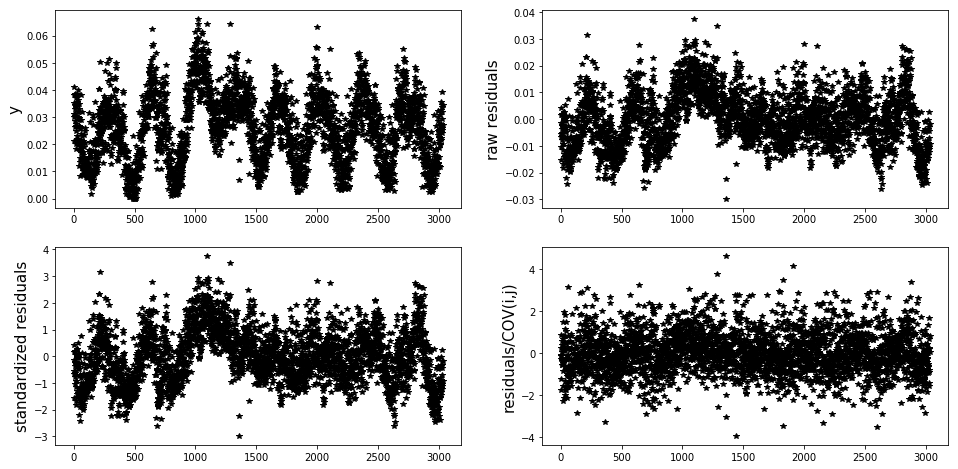

In [20]:
fig, ax = plt.subplots(2,2,figsize=(16,8))          # Set up figure and panels
ax[0,0].plot(y1,'k*')                               # plot data
ax[0,0].set_ylabel('y',fontsize=15)                 # y label
ax[0,1].plot(r.residuals(fitx1, 'response'),'k*')   # 'raw' residuals
ax[0,1].set_ylabel('raw residuals',fontsize=15) 
ax[1,0].plot(r.residuals(fitx1, 'pearson'),'k*')    # normalized to have unit variance
ax[1,0].set_ylabel('standardized residuals',fontsize=15) 
ax[1,1].plot(r.residuals(fitx1, 'normalized'),'k*') #residuals after removing the autocorrelation
ax[1,1].set_ylabel('residuals/COV(i,j)',fontsize=15)
plt.show()